#### Set up environment

In [19]:
from bs4 import BeautifulSoup as bs
from bs4 import Comment
import requests
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import numpy as np
import pandas as pd

In [20]:
import patsy
import scipy.stats as stats
from scipy.stats import boxcox 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from sklearn.linear_model import (lars_path, Lasso, LassoCV, Ridge, RidgeCV, 
                                  ElasticNet, LinearRegression)
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import warnings as skwarn
skwarn.filterwarnings('ignore')

Load the web scraped data

In [22]:
dfp = pd.read_csv("stats.csv")
dfp.drop(dfp.iloc[:,0:1], axis=1, inplace=True)
dfs = pd.read_csv("salaries.csv")
dfs.drop(dfs.iloc[:,0:1],axis=1, inplace=True)

#### Data preprocessing

Abbreviate team names for legibility

In [23]:
teamdict = {'Golden State Warriors':'GSW','Washington Wizards':'WAS', 'Oklahoma City Thunder':'OKC',\
            'Portland Trail Blazers':'POR', 'Cleveland Cavaliers':'CLE', 'Milwaukee Bucks':'MIL',\
            'Indiana Pacers':'IND', 'San Antonio Spurs':'SAS', 'Chicago Bulls':'CHI', 'Orlando Magic':'ORL',\
            'New Orleans Pelicans':'NOP', 'Utah Jazz':'UTA','New York Knicks':'NYK','Phoenix Suns':'PHO',\
            'Minnesota Timberwolves':'MIN','Philadelphia 76ers':'PHI','Denver Nuggets':'DEN',\
            'Toronto Raptors':'TOR','New Orleans Hornets':'NOH','Brooklyn Nets':'BKN','Los Angeles Clippers':'LAC',\
            'Los Angeles Lakers':'LAL','Sacramento Kings':'SAC','Miami Heat':'MIA','Boston Celtics':'BOS',\
            'Atlanta Hawks':'ATL','Houston Rockets':'HOU','Charlotte Bobcats':'CHA','Memphis Grizzlies':'MEM',\
            'New Jersey Nets':'NJN','Detroit Pistons':'DET','Charlotte Hornets':'CHO','Dallas Mavericks':'DAL'}

In [24]:
dfs['team'] = dfs.team.map(teamdict)
dfp['season'] = pd.to_numeric(dfp['season'])
df = dfp.merge(dfs, on=["player_name","season","team"], how='left')
df.replace('',np.nan, inplace=True)

In [25]:
df.dropna(subset=['salary','team'], inplace=True)
df.drop(index=4040,inplace=True)

Helper functions for data cleaning

In [26]:
def heighttoinch(x):
    return int(x.split('-')[0])*12 + int(x.split('-')[1])
df["height_in"] = df.height.apply(heighttoinch)

def cleanweight(x):
    return int(x.split('lb')[0])
df["weight_lbs"] = df.weight.apply(cleanweight)

def salaryclean(x):
    return x.split('$')[1]
df["salaryusd"] = df.salary.apply(salaryclean)

def salaryclean2(x):
    return x.replace(',','').split('.00')[0]
df["salary_usd"] = df.salaryusd.apply(salaryclean2)

In [27]:
df.drop(df[df['salary_usd']=="Minimum"].index,axis=0, inplace=True)
df.fillna(0, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')

Add the per-team and awards data

In [28]:
awards = pd.read_csv("awards.csv")
season_rec = pd.read_csv("season_record_team.csv")
playoff_rec = pd.read_csv("playoff_record_team.csv")
# dfs.drop(dfs.iloc[:,0:1],axis=1, inplace=True)

In [29]:
dfd = df.merge(awards, on=["player_name","season"], how='left')
dfd = dfd.merge(season_rec, on=["team","season"], how='left')
dfd = dfd.merge(playoff_rec, on=["team","season"], how='left')

In [30]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2791 entries, 0 to 2790
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player_name    2791 non-null   object 
 1   height         2791 non-null   object 
 2   weight         2791 non-null   object 
 3   season         2791 non-null   float64
 4   age            2791 non-null   float64
 5   team           2791 non-null   object 
 6   pos            2791 non-null   object 
 7   gameplayed     2791 non-null   float64
 8   gamestarted    2791 non-null   float64
 9   minpergame     2791 non-null   float64
 10  fgmade         2791 non-null   float64
 11  fgattempt      2791 non-null   float64
 12  fgpct          2791 non-null   float64
 13  threemade      2791 non-null   float64
 14  threeattempt   2791 non-null   float64
 15  threepct       2791 non-null   float64
 16  twomade        2791 non-null   float64
 17  twoattempt     2791 non-null   float64
 18  twopct  

#### Feature engineering
Below script is a result of an iterative process

In [31]:
dfd.fillna(0,inplace=True)

# Log-transformation to account for the distribution of salaries across the league
dfd["salary_log"] = np.log10(dfd.salary_usd)

# Simple way to quantify how far the player's team advanced into the playoffs in a season
dfd["playoff_record"] = dfd['finals']*4+dfd['conf_fin']*3+dfd['conf_semi']*2+dfd['conf_first']

# Dropping certain features: some were statistically insignificant and some simply redundant
dfmain = dfd.drop(["player_name","height","weight","team","salary","salaryusd"\
                  ,'threeattempt','threepct','MVP','ROTY','PTS','REBS','ASS','WINSHARES'\
                  ,'twoattempt','weight_lbs','twopct','ftattempt','fgattempt','allreb'\
                  ,'fgpct','finals','twomade','threemade','ftmade','fgmade','gamestarted'\
                  ,'conf_fin','conf_semi','conf_first','season','champ'], axis=1)

mask = (dfmain["pts_pg"]!=0)
dfmain = dfmain[mask]

mask = (dfmain['ftpct']>=0.1)
dfmain = dfmain[mask]

mask = (dfmain["gameplayed"]>10)
dfmain = dfmain[mask]

dfmain['min_interact'] = dfmain['minpergame'] * (dfmain['minpergame']<25)
dfmain['age_young'] = dfmain['age'] * (dfmain['age']< 23)
dfmain['age_mid'] = dfmain['age'] * ((dfmain['age'] >= 23) & (dfmain['age'] < 27))
dfmain['age_exp'] = dfmain['age'] * ((dfmain['age'] >= 27) & (dfmain['age'] < 32))
dfmain['age_vet'] = dfmain['age'] * (dfmain['age']>= 32)

# Features that reflect a player's effectiveness on per-minute basis
dfmain['drpmin'] = dfmain['defreb'] / dfmain['minpergame']
dfmain['orpmin'] = dfmain['offreb'] / dfmain['minpergame']
dfmain['ptpmin'] = dfmain['points'] / dfmain['minpergame']
dfmain['topmin'] = dfmain['turnov'] / dfmain['minpergame']
dfmain['aspmin'] = dfmain['assist'] / dfmain['minpergame']
dfmain['stpmin'] = dfmain['steals'] / dfmain['minpergame']
dfmain['blpmin'] = dfmain['blocks'] / dfmain['minpergame']
dfmain['pfpmin'] = dfmain['pfouls'] / dfmain['minpergame']

dfmain = dfmain.drop(['defreb','offreb','points','turnov','assist','steals','blocks','pfouls'], axis=1)
# dfmain = dfmain.drop(['off_eff','def_stat','shotsmade'], axis=1)
dfmain.drop_duplicates(subset=['efgpct','age','gameplayed','minpergame','ftpct'], keep='last')

dfmain.to_csv("dfmain.csv")

In [32]:
dfmain.info()
dfmain.head()
dfmain.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2666 entries, 0 to 2790
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2666 non-null   float64
 1   pos             2666 non-null   object 
 2   gameplayed      2666 non-null   float64
 3   minpergame      2666 non-null   float64
 4   efgpct          2666 non-null   float64
 5   ftpct           2666 non-null   float64
 6   height_in       2666 non-null   int64  
 7   salary_usd      2666 non-null   int64  
 8   wl_pct          2666 non-null   float64
 9   pts_pg          2666 non-null   float64
 10  opp_pts_pg      2666 non-null   float64
 11  simple_rating   2666 non-null   float64
 12  salary_log      2666 non-null   float64
 13  playoff_record  2666 non-null   float64
 14  min_interact    2666 non-null   float64
 15  age_young       2666 non-null   float64
 16  age_mid         2666 non-null   float64
 17  age_exp         2666 non-null   f

,age,gameplayed,minpergame,efgpct,ftpct,height_in,salary_usd,wl_pct,pts_pg,opp_pts_pg,simple_rating,salary_log,playoff_record,min_interact,age_young,age_mid,age_exp,age_vet,drpmin,orpmin,ptpmin,topmin,aspmin,stpmin,blpmin,pfpmin
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2.666000e+03,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,25.048012,58.804951,25.375469,0.518276,0.748438,78.570893,7.690473e+06,0.516186,106.307464,105.732183,0.567337,6.649438,5.608027,7.553301,6.139910,9.206302,7.769317,1.932483,0.141888,0.046908,0.432869,0.057059,0.097637,0.033134,0.021841,0.084763
std,3.716797,20.096975,8.277876,0.060120,0.108655,3.341989,7.916311e+06,0.148235,6.557997,6.570049,4.517947,0.483146,10.195415,9.283365,9.546859,11.857258,12.746351,7.786211,0.055979,0.034439,0.131221,0.021082,0.061865,0.012349,0.019372,0.028377
min,19.000000,11.000000,3.200000,0.063000,0.174000,70.000000,9.474000e+03,0.122000,88.400000,88.200000,-10.660000,3.976533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.022857
25%,22.000000,46.000000,19.200000,0.483000,0.693000,76.000000,1.960560e+06,0.402000,101.600000,100.900000,-2.080000,6.292380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099455,0.021739,0.336801,0.042131,0.051471,0.024096,0.009009,0.065574
50%,25.000000,64.000000,26.600000,0.516000,0.767000,79.000000,4.334680e+06,0.528000,106.300000,106.500000,0.590000,6.636957,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130287,0.033708,0.414256,0.053968,0.078868,0.031915,0.015625,0.080440
75%,28.000000,76.000000,32.200000,0.550000,0.824000,81.000000,1.155600e+07,0.622000,111.800000,110.500000,3.817500,7.062807,6.000000,17.100000,20.000000,24.000000,27.000000,0.000000,0.173026,0.065217,0.510687,0.068966,0.131967,0.040816,0.028169,0.097934
max,37.000000,82.000000,42.500000,0.742000,1.000000,88.000000,4.300636e+07,0.890000,120.100000,119.700000,11.350000,7.633533,40.000000,24.900000,22.000000,26.000000,31.000000,37.000000,0.375000,0.204819,0.980978,0.156593,0.332386,0.098039,0.155172,0.253165


#### Regression
Split data for train/test/validation

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  

X_train, X, y_train, y = train_test_split(dfmain.drop(['pos','salary_usd','salary_log'],axis=1), dfmain['salary_log'], test_size=0.2, random_state=27)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

Baseline OLS

In [34]:
lm = LinearRegression()
lm.fit(X_tr, y_tr)

lm_score = lm.score(X_val, y_val)

print(f"Baseline linear regression model r^2 score: {lm_score}")
for feature, coef in zip(X_tr.columns, lm.coef_):
    print(feature, ':', f'{coef:.2f}') 

Baseline linear regression model r^2 score: 0.5745786229518952
age : 235182776161.92
gameplayed : 0.00
minpergame : 0.02
efgpct : -0.99
ftpct : -0.32
height_in : 0.02
wl_pct : -0.17
pts_pg : 0.08
opp_pts_pg : -0.07
simple_rating : -0.06
playoff_record : -0.00
min_interact : -0.00
age_young : -235182776161.89
age_mid : -235182776161.88
age_exp : -235182776161.88
age_vet : -235182776161.88
drpmin : 0.27
orpmin : 0.06
ptpmin : 0.58
topmin : 1.25
aspmin : 0.52
stpmin : -1.79
blpmin : 0.89
pfpmin : -1.89


Deeper evaluation of coefficients and regression outputs with OLS

In [35]:
model = sm.OLS(y_train, X_train) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             salary_log   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          4.226e+04
Date:                Thu, 20 Jan 2022   Prob (F-statistic):                        0.00
Time:                        17:23:12   Log-Likelihood:                         -529.23
No. Observations:                2132   AIC:                                      1104.
Df Residuals:                    2109   BIC:                                      1235.
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
age                0.0409      0.004      9.523      0.000       0.032       0.049
gameplayed         0.0004      0.000      1.000      0.317      -0.000       0.001
minpergame         0.0257      0.001     17.607      0.000       0.023       0.029
efgpct            -0.9380      0.145     -6.468      0.000      -1.222      -0.654
ftpct             -0.2741      0.078     -3.533      0.000      -0.426      -0.122
height_in          0.0391      0.002     16.841      0.000       0.035       0.044
wl_pct             0.1715      0.171      1.002      0.317      -0.164       0.507
pts_pg             0.0793      0.021      3.861      0.000       0.039       0.120
opp_pts_pg        -0.0598      0.020     -2.940      0.003      -0.100      -0.020
simple_rating     -0.0656      0.021     -3.188      0.001      -0.106      -0.025
playoff_record    -0.0019      0.001     -2.197      0.028      -0.004      -0.000
min_interact       0.0002      0.001      0.173      0.863      -0.002       0.002
age_young          0.0116      0.002      4.879      0.000       0.007       0.016
age_mid            0.0099      0.001      6.789      0.000       0.007       0.013
age_exp            0.0116      0.001     15.283      0.000       0.010       0.013
age_vet            0.0078      0.001     10.402      0.000       0.006       0.009
drpmin            -0.3188      0.190     -1.674      0.094      -0.692       0.055
orpmin             0.0344      0.357      0.097      0.923      -0.665       0.734
ptpmin             0.4599      0.081      5.677      0.000       0.301       0.619
topmin             1.7371      0.570      3.048      0.002       0.620       2.855
aspmin             0.8221      0.202      4.079      0.000       0.427       1.217
stpmin            -0.8878      0.622     -1.427      0.154      -2.108       0.333
blpmin             0.5035      0.508      0.991      0.322      -0.493       1.500
pfpmin            -2.0662      0.352     -5.867      0.000      -2.757      -1.376
==============================================================================
Omnibus:                      236.904   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              508.690
Skew:                          -0.677   Prob(JB):                    3.46e-111
Kurtosis:                       4.972   Cond. No.                     6.41e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.75e-24. This might indicate that there ar

In [36]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

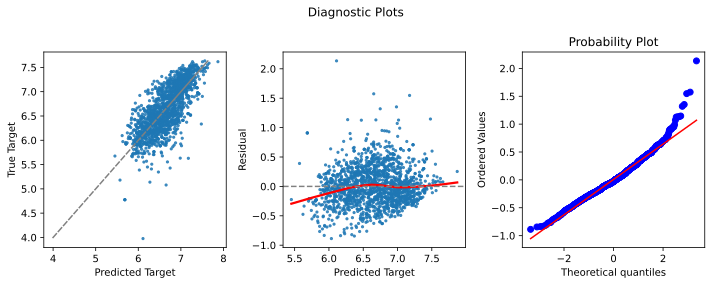

In [37]:
fit_tr = lm.fit(X_tr,y_tr)
fit_val = lm.fit(X_val,y_val)
diagnostic_plots(fit_tr.predict(X_tr), y_tr, fit_tr.predict(X_tr)-y_tr)

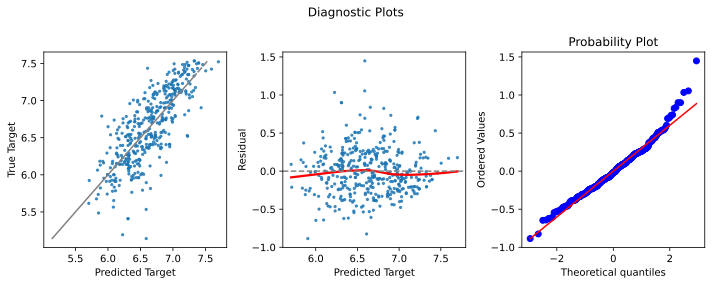

In [38]:
diagnostic_plots(fit_val.predict(X_val), y_val, fit_val.predict(X_val)-y_val)

Residuals vs. Predict Target (middle) charts aren't perfect, but without a distinctive pattern, the assumptions of linear regression seem roughly met. Probability plot (right) has some deviations towards the right end and there may be room for improvement with the outlieres in the dataset.

<AxesSubplot:xlabel='salary_log', ylabel='Count'>

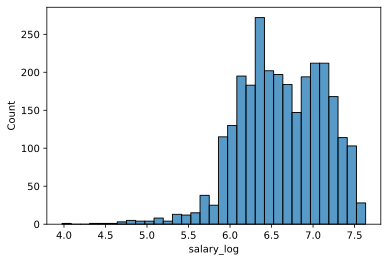

In [39]:
# sns.histplot(dfd.salary_usd)
sns.histplot(dfd.salary_log)

#### Feature selection & reduction

In [40]:
def build_grid_search_est(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                            return_train_score=False)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
#       plt.plot(np.log(df.alpha), df.mean_test_score);
        plt.semilogx(df.alpha, df.mean_test_score)
    return grid_est

In [41]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

Lasso Grid Search


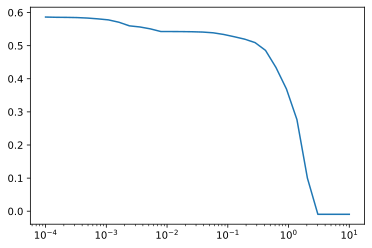

In [42]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_tr, y_tr, cv=kfold,
                                       alpha=np.logspace(-4, 1, 30))

Ridge Grid Search


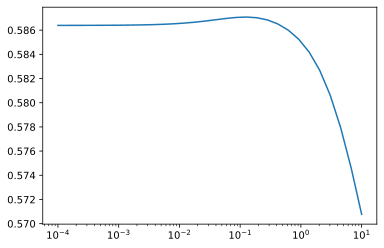

In [43]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_tr, y_tr, cv=kfold,
                                       alpha=np.logspace(-4, 1, 30))

Elastic Net Grid Search


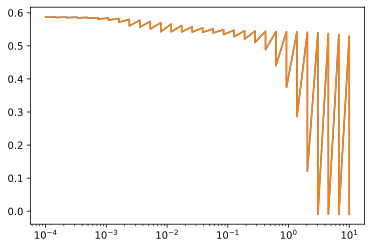

In [44]:
print("Elastic Net Grid Search")
elastic_net_grid_est = build_grid_search_est(ElasticNet(), X_tr, y_tr, cv=kfold,
                                             alpha=np.logspace(-4, 1, 30),
                                             l1_ratio=np.linspace(0,1,30,endpoint=False))

In [45]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = lm.predict(X_val)
print("Linear Regression:", r2_score(y_val, y_pred))

y_pred = lasso_grid_est.predict(X_val)
print("Lasso Regression:", r2_score(y_val, y_pred))

y_pred = ridge_grid_est.predict(X_val)
print("Ridge Regression:", r2_score(y_val, y_pred))

y_pred = elastic_net_grid_est.predict(X_val)
print("ElasticNet Regression:", r2_score(y_val, y_pred))

Linear Regression: 0.61243068558074
Lasso Regression: 0.5722932277724893
Ridge Regression: 0.5725061776714871
ElasticNet Regression: 0.5723729398370624


In [46]:
lmcoef = pd.DataFrame(list(zip(X.columns, lm.coef_)), columns=["predvar","lm"])
lassocoef = pd.DataFrame(list(zip(X.columns, lasso_grid_est.best_estimator_.coef_)), columns=["predvar","lasso"])
ridgecoef = pd.DataFrame(list(zip(X.columns, ridge_grid_est.best_estimator_.coef_)), columns=["predvar","ridge"])
elasticcoef = pd.DataFrame(list(zip(X.columns, elastic_net_grid_est.best_estimator_.coef_)), columns=["predvar","elast"])

coefdf = lmcoef.merge(lassocoef, on=["predvar"], how='left').merge(ridgecoef, on=["predvar"], how='left').merge(elasticcoef, on=["predvar"], how='left')
coefdf

,predvar,lm,lasso,ridge,elast
0,age,0.024446,0.039608,0.030879,0.041200
1,gameplayed,-0.000464,0.000220,0.000245,0.000241
2,minpergame,0.031220,0.024499,0.024527,0.024577
3,efgpct,-0.619071,-0.956905,-0.984192,-0.974899
4,ftpct,-0.415364,-0.333159,-0.324767,-0.326202
5,height_in,0.006402,0.023265,0.022219,0.022298
6,wl_pct,0.139605,-0.104025,-0.176292,-0.162695
7,pts_pg,0.061840,0.067717,0.079791,0.071361
8,opp_pts_pg,-0.040703,-0.053215,-0.065098,-0.056829
9,simple_rating,-0.045967,-0.049334,-0.059263,-0.051259


Based on the above, the reduced set of features are as follows:

In [48]:
df2 = dfmain[["age",'gameplayed','minpergame','efgpct','ftpct','height_in','pts_pg','opp_pts_pg',\
            'simple_rating','playoff_record','min_interact','age_young','age_mid','age_exp','age_vet',\
            'drpmin','ptpmin','aspmin','pfpmin','salary_log']]

In [49]:
# df2.to_csv('df2.csv')

#### Excursus: Polynomial Regression
To check for appropriateness of polynomial regression for this dataset

In [50]:
from sklearn.preprocessing import PolynomialFeatures

In [51]:
X_train, X, y_train, y = train_test_split(df2.drop(['salary_log'],axis=1), df2['salary_log']\
                                          , test_size=0.2, random_state=27)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=34)  

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_tr_poly = poly.fit_transform(X_tr)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_tr_poly,y_tr)
lr_poly.score(X_tr_poly,y_tr)

0.6955223678254412

In [52]:
lr_poly.score(X_val_poly, y_val)

0.6205856261376241

Seems to be overfitting, given the difference in training and validation score

In [54]:
print(dict(zip(X_val.columns,lr_poly.coef_)))

{'age': 2.2449913219843511e-10, 'gameplayed': -108021.1313185379, 'minpergame': 0.043674905367185074, 'efgpct': -0.11416556009575526, 'ftpct': -0.24082208910735262, 'height_in': -4.532816374162644, 'pts_pg': -0.5274026483193344, 'opp_pts_pg': 0.9481817209547653, 'simple_rating': -0.8158794498733339, 'playoff_record': -0.5868958146649957, 'min_interact': -0.1489845406057856, 'age_young': -0.03284659424081211, 'age_mid': 108021.66421939299, 'age_exp': 108021.36870149302, 'age_vet': 108021.4347600256, 'drpmin': 108021.46455225683, 'ptpmin': 17.04931265901563, 'aspmin': 13.268153131488292, 'pfpmin': -22.79987848554809}


#### Comparing OLS & regularization outputs

In [55]:
# Check on the multicollinearity issue - needs ridge and/or lasso regularization
# Drop defensive rebounds per min, but keep the interaction features (ignore p-val)
model = sm.OLS(y_train, X_train) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             salary_log   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          5.379e+04
Date:                Thu, 20 Jan 2022   Prob (F-statistic):                        0.00
Time:                        17:24:18   Log-Likelihood:                         -535.81
No. Observations:                2132   AIC:                                      1108.
Df Residuals:                    2114   BIC:                                      1210.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
age                0.0407      0.004      9.700      0.000       0.032       0.049
gameplayed         0.0004      0.000      1.077      0.281      -0.000       0.001
minpergame         0.0252      0.001     17.464      0.000       0.022       0.028
efgpct            -0.9940      0.138     -7.204      0.000      -1.265      -0.723
ftpct             -0.3266      0.073     -4.472      0.000      -0.470      -0.183
height_in          0.0416      0.002     19.616      0.000       0.037       0.046
pts_pg             0.0756      0.020      3.755      0.000       0.036       0.115
opp_pts_pg        -0.0567      0.020     -2.845      0.004      -0.096      -0.018
simple_rating     -0.0578      0.020     -2.828      0.005      -0.098      -0.018
playoff_record    -0.0017      0.001     -1.959      0.050      -0.003    1.65e-06
min_interact      -0.0002      0.001     -0.191      0.849      -0.002       0.002
age_young          0.0116      0.002      5.008      0.000       0.007       0.016
age_mid            0.0097      0.001      6.832      0.000       0.007       0.013
age_exp            0.0115      0.001     15.336      0.000       0.010       0.013
age_vet            0.0078      0.001     10.493      0.000       0.006       0.009
drpmin            -0.2160      0.162     -1.334      0.182      -0.533       0.101
ptpmin             0.6049      0.068      8.911      0.000       0.472       0.738
aspmin             1.1611      0.138      8.398      0.000       0.890       1.432
pfpmin            -1.7285      0.317     -5.457      0.000      -2.350      -1.107
==============================================================================
Omnibus:                      241.139   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              526.673
Skew:                          -0.683   Prob(JB):                    4.31e-115
Kurtosis:                       5.016   Cond. No.                     6.62e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.64e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Applying LASSO CV again for final set of predictor variables

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_tr.values, y_tr)
    
    val_set_pred = pipe.predict(X_val.values)
    err_vec_val[i] = mae(y_val, val_set_pred)

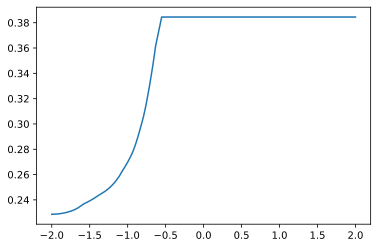

In [57]:
plt.plot(np.log10(alphalist), err_vec_val)

In [58]:
np.min(err_vec_val)

0.22858501255680375

In [59]:
alphalist[np.argmin(err_vec_val)]

0.01

In [60]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [61]:
X_tr_std = std.transform(X_tr.values)
X_std = std.transform(X.values)

In [62]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_std, y)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [63]:
lasso_model.alpha_

0.01

In [86]:
# These are the (standardized) coefficients found when refit using the best alpha
list(zip(X.columns, lasso_model.coef_))

[('age', 0.17465659986720597),
 ('gameplayed', 0.0),
 ('minpergame', 0.20349603807576894),
 ('efgpct', -0.044404781334110396),
 ('ftpct', -0.007065649462709027),
 ('height_in', 0.03769125485396224),
 ('opp_pts_pg', 0.056859743582317976),
 ('playoff_record', 0.0),
 ('min_interact', 0.005104391389197212),
 ('age_young', -0.0),
 ('age_mid', -0.007836867552649875),
 ('age_exp', -0.0),
 ('age_vet', -0.0),
 ('drpmin', 0.02799894628316658),
 ('ptpmin', 0.0),
 ('aspmin', 0.022481246949618686),
 ('pfpmin', 0.06845124600847852),
 ('actual', 0.023378920065990422),
 ('ridge_pred', -0.03025469578482042)]

In [65]:
df2.corr()>0.5

,age,gameplayed,minpergame,efgpct,ftpct,height_in,pts_pg,opp_pts_pg,simple_rating,playoff_record,min_interact,age_young,age_mid,age_exp,age_vet,drpmin,ptpmin,aspmin,pfpmin,salary_log
age,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False
gameplayed,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
minpergame,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
efgpct,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ftpct,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
height_in,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
pts_pg,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
opp_pts_pg,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
simple_rating,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
playoff_record,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False


#### Cross check with LARS path

In [66]:
X_tr, X, y_tr, y = train_test_split(df2.drop(['salary_log'],axis=1), df2['salary_log'], test_size=0.2, random_state=27)

std = StandardScaler()
std.fit(X_tr.values)
X_tr_tr = std.transform(X_tr.values)

In [67]:
print("Computing regularization path using the LARS ...")
alphas, order, coefs = lars_path(X_tr_tr, y_tr.values, method='lasso')

Computing regularization path using the LARS ...


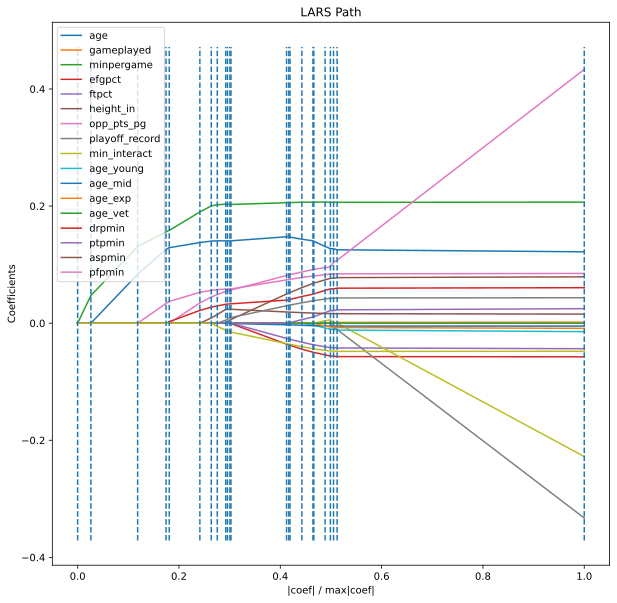

In [87]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LARS Path')
plt.axis('tight')
plt.legend(X_tr.columns) # look at the row below
plt.show()

#### Final fit and test

In [70]:
X_tr, X, y_tr, y = train_test_split(df2.drop(['pts_pg','simple_rating','salary_log'],axis=1), df2['salary_log'], test_size=0.2, random_state=27)

In [71]:
def finalfits(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, scoring='neg_mean_absolute_error',
                            return_train_score=False)
    grid_est.fit(X, y)
    return grid_est

lm_f = finalfits(lm, X_tr, y_tr, cv=kfold)    
lasso_f = finalfits(Lasso(), X_tr, y_tr, cv=kfold, alpha=np.logspace(-2, 1, 30))
ridge_f = finalfits(Ridge(), X_tr, y_tr, cv=kfold, alpha=np.logspace(-2, 1, 30))
en_f = finalfits(ElasticNet(), X_tr, y_tr, cv=kfold, alpha=np.logspace(-2, 1, 30),\
                                             l1_ratio=np.linspace(0,1,30,endpoint=False))

lm_pred = lm_f.predict(X)
print("Linear Regression:", '\t',f'{r2_score(y, lm_pred):.4f}', '\t', f'{10**mean_squared_error(y, lm_pred):.1f}')

la_pred = lasso_f.predict(X)
print("Lasso Regression:", '\t',f'{r2_score(y, la_pred):.4f}', '\t', f'{10**mean_squared_error(y, la_pred):.1f}')

r_pred = ridge_f.predict(X)
print("Ridge Regression:", '\t',f'{r2_score(y, r_pred):.4f}', '\t', f'{10**mean_squared_error(y, r_pred):.1f}')

e_pred = en_f.predict(X)
print("ElasticNet Regression:", '\t', f'{r2_score(y, e_pred):.4f}', '\t', f'{10**mean_squared_error(y, e_pred):.1f}')

Linear Regression: 	 0.6066 	 1.2
Lasso Regression: 	 0.5618 	 1.3
Ridge Regression: 	 0.6063 	 1.2
ElasticNet Regression: 	 0.5856 	 1.2


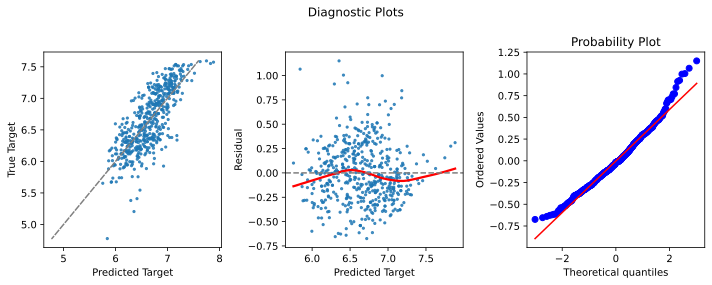

In [72]:
diagnostic_plots(lm_pred, y, lm_pred-y)

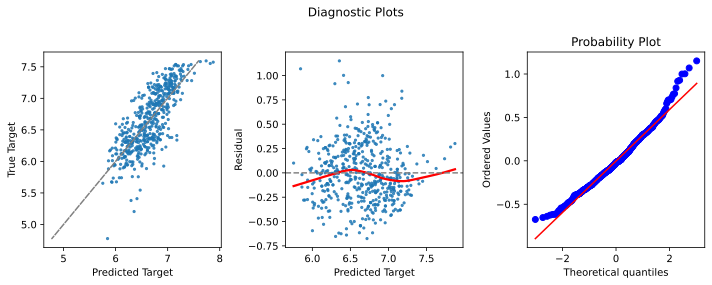

In [73]:
diagnostic_plots(r_pred, y, r_pred-y)

#### Ridge regression model output evaluation

In [74]:
outputdf = pd.DataFrame(ridge_f.cv_results_)

In [77]:
ridge_f.best_estimator_.coef_

array([ 3.01224116e-02,  4.77150170e-04,  2.21228030e-02, -7.32988637e-01,
       -3.81933795e-01,  2.16871266e-02,  1.06150220e-02,  2.26392529e-03,
       -1.31554528e-03,  4.39723615e-03,  5.81262842e-03,  1.07995750e-02,
        9.11297179e-03,  3.10527089e-01,  6.97883974e-01,  7.29714394e-01,
       -1.61221649e+00])

In [78]:
X_tr.columns

Index(['age', 'gameplayed', 'minpergame', 'efgpct', 'ftpct', 'height_in',
       'opp_pts_pg', 'playoff_record', 'min_interact', 'age_young', 'age_mid',
       'age_exp', 'age_vet', 'drpmin', 'ptpmin', 'aspmin', 'pfpmin'],
      dtype='object')

In [79]:
ridge_out = pd.DataFrame(ridge_f.best_estimator_.coef_,np.array(X_tr.columns),columns=['coef'])

Top 2 positively correlated with salary:   Assists per minute ("aspmin") and Points per minute (ptpmin")

Top 2 negatively correlated with salary:   Effective field goal % ("efgpct") and personal fouls per minute ("pfpmin")

<AxesSubplot:>

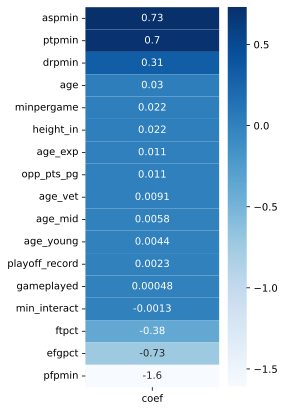

In [80]:
coefin = ridge_out.sort_values(by="coef", ascending=False)

coefin10 = np.array(10**coefin)

fig, ax = plt.subplots(figsize=(3,7))
sns.heatmap(data=coefin, annot=True, cmap="Blues", ax=ax)